In [56]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from fastai import *
from fastai.vision import *
import warnings
from sklearn.model_selection import StratifiedKFold
class Data(object):
    def __init__(self, h5, ratio = 0.8):
        h = h5py.File(h5, 'r')
        self.img = h['img']
        self.msk = h['msk']
        self.lbl = h['lbl']
        self.meanstd = h['meanstd']
        length = self.lbl.shape[0]
        lennames = len(set(self.lbl[:,0]))
        self.trainidx = np.arange(round(ratio * lennames))
        self.validx = np.arange(round(ratio * lennames), lennames)
        self.trans = torchvision.transforms.Compose([
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomVerticalFlip(),
            torchvision.transforms.RandomRotation(15)
        ])
#         self.trans = None

    def toLoader(self, batch_size):
        trainDataset = self.Dataset(self.img, self.msk, self.lbl, self.meanstd, self.trainidx, trans = self.trans)
        valDataset = self.Dataset(self.img, self.msk, self.lbl, self.meanstd, self.validx)
        trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size = batch_size, shuffle = True, num_workers = 4, drop_last = True)
        valLoader = torch.utils.data.DataLoader(valDataset, batch_size = 1, shuffle = False, num_workers = 4)
        return ImageDataBunch(trainLoader, valLoader, device = "cuda")

    def toBagLoader(self, batch_size, bag_ratio = 0.8):
        bagidx = np.random.choice(self.trainidx, round(bag_ratio * len(self.trainidx)))
        trainDataset = self.Dataset(self.img, self.msk, self.lbl, self.meanstd, bagidx, trans = self.trans)
        valDataset = self.Dataset(self.img, self.msk, self.lbl, self.meanstd, self.validx)
        trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size = batch_size, shuffle = True, num_workers = 4, drop_last = True)
        valLoader = torch.utils.data.DataLoader(valDataset, batch_size = 1, shuffle = False, num_workers = 4)
        return ImageDataBunch(trainLoader, valLoader, device = "cuda")

    class Dataset(torch.utils.data.Dataset):
        def __init__(self, img, msk, lbl, meanstd, idx, trans = None):
            self.img = img
            self.msk = msk
            self.lbl = lbl[:,3].astype(np.int)
            self.mean = meanstd[0][np.newaxis, :, np.newaxis, np.newaxis]
            self.std = meanstd[1][np.newaxis, :, np.newaxis, np.newaxis]
            self.idx = idx
            self.trans = trans

        def __getitem__(self, i):
            x = self.img[self.idx[i] * 16:(self.idx[i] + 1) * 16]
            y = self.lbl[self.idx[i] * 16]
            if self.trans:
                for j in range(len(x)):
                    x[j] = np.array(self.trans(PIL.Image.fromarray((255 - x[j]).transpose(1, 2, 0)))).transpose((2, 0, 1))
            x = (x / 255. - 1 + self.mean) / np.sqrt(self.std)
            return x, y

        def __len__(self):
            return len(self.idx)
D = Data("/home/zhaoxun/codes/Panda/_data/v0.h5")
# h5 = h5py.File("/home/zhaoxun/codes/Panda/_data/v0.h5", 'r')
# my16 = h5['img'][16:32].transpose((0, 2, 3, 1))
# my16 = np.concatenate([np.concatenate([my16[i * 4 + j] for j in range(4)], axis = 0) for i in range(4)], axis = 1)
# mean = h5['meanstd'][0]
# std = np.sqrt(h5['meanstd'][1])
# my16 = -(my16 / 255 - mean) / std
# norm = lambda x: (((x - np.min(x)) / np.ptp(x)) * 255).astype(np.int)
# plt.imshow(norm(my16))

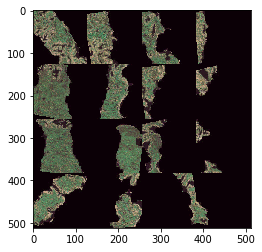

In [59]:
dl = D.toLoader(1)
for x, y in dl.train_dl:
    break
my16 = x[0].cpu().data.numpy().transpose((0, 2, 3, 1))
my16 = np.concatenate([np.concatenate([my16[i * 4 + j] for j in range(4)], axis = 0) for i in range(4)], axis = 1)
# mean = h5['meanstd'][0]
# std = np.sqrt(h5['meanstd'][1])
# my16 = -(my16 / 255 - mean) / std
norm = lambda x: (((x - np.min(x)) / np.ptp(x)) * 255).astype(np.int)
plt.imshow(norm(my16))
# torch.from_numpy(np.arange(10))

205


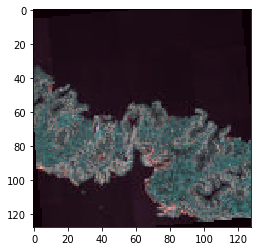

In [51]:
trans = torchvision.transforms.Compose([
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomVerticalFlip(),
            torchvision.transforms.RandomRotation(15)
        ])
h5 = h5py.File("/home/zhaoxun/codes/Panda/_data/v0.h5", 'r')
x = h5['img'][0].transpose((1, 2, 0))
x = PIL.Image.fromarray(255 - x)
x = trans(x)
mean = np.array([0.90949707, 0.8188697, 0.87795304])
std = np.array([0.36357649, 0.49984502, 0.40477625])
print(np.max(x))
x = (np.array(x) / 255. - (1 - mean)) / std
plt.imshow(norm(x))

In [65]:
df = pd.read_csv(LABELS).set_index('image_id')
files = sorted(set([p[:32] for p in os.listdir(TRAIN)]))
df = df.loc[files]
df = df.reset_index()
splits = StratifiedKFold(n_splits=nfolds, random_state=SEED, shuffle=True)
splits = list(splits.split(df,df.isup_grade))
folds_splits = np.zeros(len(df)).astype(np.int)
for i in range(nfolds): 
    folds_splits[splits[i][1]] = i
df['split'] = folds_splits
df = df.iloc[4696:4700,:]
data = get_data()

/data/zhaoxun/miniconda3/envs/torch/lib/python3.6/site-packages/fastai/data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


In [66]:
for X, y in data.train_dl:
    break
print(len(X))
X[0].shape

16


torch.Size([2, 3, 128, 128])

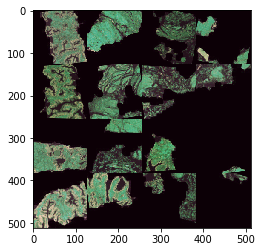

In [11]:
ml = MImageItemList.from_df(df, path='/', folder=TRAIN, cols='image_id')
his = np.stack([x[0].cpu().data.numpy().transpose(1, 2, 0) for x in X])
his = np.concatenate([np.concatenate([his[i * 4 + j] for j in range(4)], axis = 0) for i in range(4)], axis = 1)
plt.imshow(norm(his))

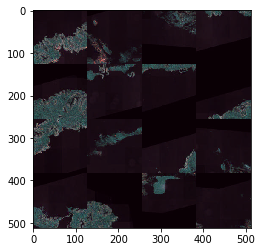

In [6]:
ml = MImageItemList.from_df(df, path='/', folder=TRAIN, cols='image_id')
his = np.stack([(x.data.numpy() * 255).astype(np.int).transpose(1, 2, 0) for x in ml.get(0).data])
his = np.concatenate([np.concatenate([his[i * 4 + j] for j in range(4)], axis = 0) for i in range(4)], axis = 1)
norm = lambda x: (((x - np.min(x)) / np.ptp(x)) * 255).astype(np.int)
plt.imshow(norm(his))

In [64]:
from fastai import *
from fastai.vision import *
import warnings
from sklearn.model_selection import StratifiedKFold
TRAIN = "/home/zhaoxun/codes/Panda/_data/iafoss/train"
LABELS = '/home/zhaoxun/codes/Panda/_data/train.csv'
nfolds = 5
SEED = 0
mean = torch.tensor([1.0-0.90949707, 1.0-0.8188697, 1.0-0.87795304])
std = torch.tensor([0.36357649, 0.49984502, 0.40477625])
df = pd.read_csv(LABELS).set_index('image_id')
sz = 128
bs = 2
N = 16
def open_image(fn:PathOrStr, div:bool=True, convert_mode:str='RGB', cls:type=Image,
    after_open:Callable=None)->Image:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        x = PIL.Image.open(fn).convert(convert_mode)
    if after_open: x = after_open(x)
    x = pil2tensor(x,np.float32)
    if div: x.div_(255)
    return cls(1.0-x) #invert image for zero padding

class MImage(ItemBase):
    def __init__(self, imgs):
        self.obj, self.data = \
        (imgs), [(imgs[i].data - mean[...,None,None])/std[...,None,None] for i in range(len(imgs))]
    
    def apply_tfms(self, tfms,*args, **kwargs):
        for i in range(len(self.obj)):
            self.obj[i] = self.obj[i].apply_tfms(tfms, *args, **kwargs)
            self.data[i] = (self.obj[i].data - mean[...,None,None])/std[...,None,None]
        return self
    
    def __repr__(self): return f'{self.__class__.__name__} {img.shape for img in self.obj}'

    def to_one(self):
        img = torch.stack(self.data,1)
        img = img.view(3,-1,N,sz,sz).permute(0,1,3,2,4).contiguous().view(3,-1,sz*N)
        return Image(1.0 - (mean[...,None,None]+img*std[...,None,None]))

class MImageItemList(ImageList):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def __len__(self)->int: return len(self.items) or 1 
    
    def get(self, i):
        fn = Path(self.items[i])
        fnames = [Path(str(fn)+'_'+str(i)+'.png')for i in range(N)]
        imgs = [open_image(fname, convert_mode=self.convert_mode, after_open=self.after_open)
            for fname in fnames]
        return MImage(imgs)

    def reconstruct(self, t):
        return MImage([mean[...,None,None]+_t*std[...,None,None] for _t in t])
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(300,50), **kwargs):
        rows = min(len(xs),8)
        fig, axs = plt.subplots(rows,1,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()
        

#collate function to combine multiple images into one tensor
def MImage_collate(batch:ItemsList)->Tensor:
    result = torch.utils.data.dataloader.default_collate(to_data(batch))
    if isinstance(result[0],list):
        result = [torch.stack(result[0],1),result[1]]
    return result

def get_data(fold=0):
    return (MImageItemList.from_df(df, path='/', folder=TRAIN, cols='image_id')
    .split_by_idx(df.index[df.split == fold].tolist())
    .label_from_df(cols=['isup_grade'])
    .transform(get_transforms(flip_vert=True,max_rotate=15),size=sz,padding_mode='zeros')
    .databunch(bs=bs,num_workers=4))